In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from data.fetchdata import getProvinceData, getCountryData
from models import SSEIR, DSEIR, PDSEIR
from utils import dataPrepare, dataPrepareWithTime, computeBeta, \
                computeGamma, predict_and_plot, predict_and_plot_dyn

In [2]:
d, con, rec = getProvinceData("浙江省")
#d, con, rec = getCountryData("IT")


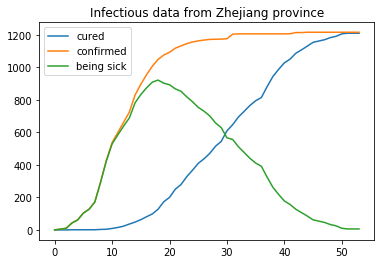

In [3]:
plt.plot(rec, label='cured')
plt.plot(con, label='confirmed')
plt.plot(con-rec, label='being sick')
plt.legend(loc='upper left')
plt.title("Infectious data from Zhejiang province")

In [4]:
province_population = 54000000
X, y = dataPrepare(province_population, con, rec, 4)

X_train = X[:40,:]
y_train = y[:40,:]
d_train = d[:40]

## Static SEIR Model

- $\sigma$: $\frac{1}{incubation time}$ ~ [$\frac{1}{14}$, 1]
- $\gamma$: $\frac{1}{recovery time}$ ~ [$\frac{1}{17+4}$, $\frac{1}{17-4}$]
- $\beta$: $R_0 = \frac{\beta}{\gamma}$, $R_0$ of COVID-19 is around 1.4~3.8, so $\beta$ ~ [0.067, 0.292]

In [ ]:
sseir = SSEIR(beta_range=[0.066, 0.292], sigma_range=[1.0/14, 1.0], gamma_range=[1.0/21, 1.0/13])
sseir = sseir.float()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([sseir.params], lr=0.0003)

# Regularization parameters
num_epoch = 500
lam0 = 0.2
lam1 = 10000
lam2 = 10000
lam3 = 10000

for epoch in range(num_epoch):
    ids = np.random.permutation(X_train.shape[0])
    epoch_loss = 0.0
    for sample_id in ids:
        currday = torch.from_numpy(X_train[sample_id])
        nextInfected = torch.from_numpy(y_train[sample_id])
        
        optimizer.zero_grad()
        out = sseir(currday.float())
        preInfected = out[2]
        loss = criterion(preInfected, nextInfected.float())
        epoch_loss += loss.item()
        reg = lam1*(F.relu(sseir.params[0]-sseir.betaH) + F.relu(sseir.betaL-sseir.params[0])) \
             +lam2*(F.relu(sseir.params[1]-sseir.sigmaH) + F.relu(sseir.sigmaL-sseir.params[1])) \
             +lam3*(F.relu(sseir.params[2]-sseir.gammaH) + F.relu(sseir.gammaL-sseir.params[2]))
        loss = lam0*loss + (1-lam0)*reg
        # epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print (epoch_loss/len(ids))
    

[0.0667696  0.02061561 0.07703857]


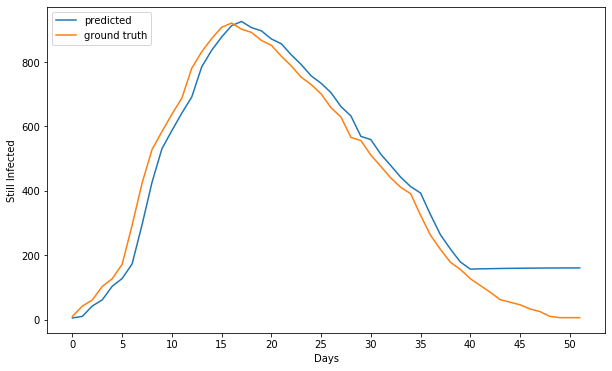

Mean Absolute Error of unseen data:  112.13826126261131


In [6]:
print (sseir.params.detach().numpy())
s_pre, mape = predict_and_plot(X, y, d, 40, sseir.params.detach().numpy())
print ("Mean Absolute Error of unseen data: ", mape)

## Dynamic SEIR Model

In [7]:
province_population = 57000000
X, y = dataPrepareWithTime(province_population, con, rec, 4)

X_train = X[:40,:]
y_train = y[:40,:]
d_train = d[:40]

In [8]:
dseir = DSEIR(sigma=0.02531358)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([dseir.params], lr=0.0002)

In [ ]:
dseir = DSEIR(sigma=0.02531358)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([dseir.params], lr=0.0002)
num_epoch = 500

# Regularization parameters
lam0 = 0.5
lam1 = 100
lam2 = 1000

for epoch in range(num_epoch):
    ids = np.random.permutation(X_train.shape[0])
    epoch_loss = 0.0
    for sample_id in ids:
        currday = torch.from_numpy(X_train[sample_id])
        nextInfected = torch.from_numpy(y_train[sample_id])
        
        optimizer.zero_grad()
        out = dseir(currday.float())
        preInfected = out[2]
        loss = criterion(preInfected, nextInfected.float())
        epoch_loss += loss.item()
        reg = lam1 * F.relu(dseir.params[0] - 0.3) + lam2 * F.relu(0.06 - dseir.params[0])
        loss = lam0*loss + (1-lam0)*reg
        loss.backward()
        optimizer.step()
    print (epoch_loss/len(ids))
    

[ 0.2998284   0.32986495 -0.7497504  -0.00655796 -0.45523375  0.07989599
  0.17507005  0.3685977 ]


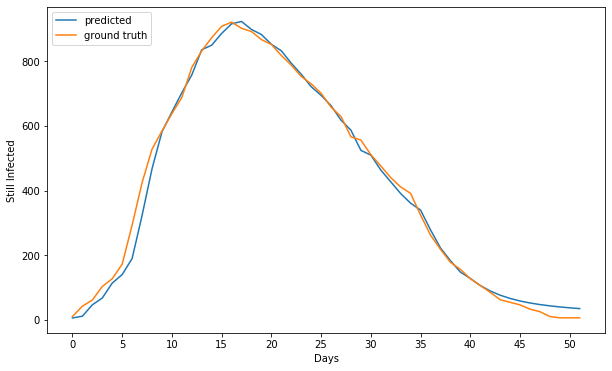

Mean Absolute Error of unseen data:  17.519601660289563


In [10]:
print (dseir.params.detach().numpy())
d_pre, mape = predict_and_plot_dyn(X, y, d, 40, dseir.params.detach().numpy())
print ("Mean Absolute Error of unseen data: ", mape)

## Result comparison

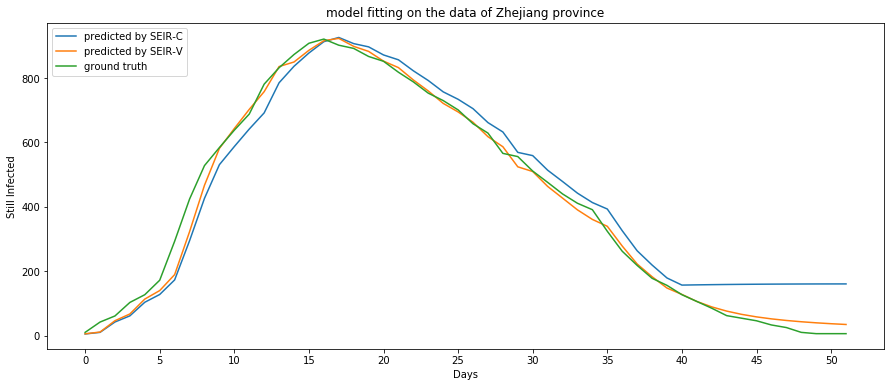

In [11]:
plt.figure(figsize=(15,6))
plt.plot(s_pre, label="predicted by SEIR-C")
plt.plot(d_pre, label="predicted by SEIR-V")
plt.plot(y, label="ground truth")
plt.legend(loc='upper left')
plt.xlabel("Days")
plt.ylabel("Still Infected")
plt.xticks(np.arange(0, len(y), 5))
plt.title("model fitting on the data of Zhejiang province")
plt.savefig("zhejiang.png")
plt.show()